In [140]:
import os
import numpy as np
import pandas as pd
import scipy
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
import tensorflow as tf
from sklearn.model_selection import train_test_split, KFold
from mllib.model import KerasSurrogate
from helper_functions.scan_helper_functions import AdjustedRSquared
from helper_functions.ml_helper_functions import RSquaredSeparated, AdjustedRSquaredSeparated
from helper_functions.invertible_neural_network import InvertibleNetworkSurrogate
from sklearn.metrics import mean_absolute_error, mean_squared_error, explained_variance_score,mean_absolute_percentage_error

In [141]:
seed = 49857
tf.random.set_seed(seed)
np.random.seed(seed)

### Config

In [142]:
directory = os.path.dirname(os.path.dirname(os.getcwd()))
directory

'/data/user/ammann_r/aerosol'

In [143]:
test_datafile = directory +'/aerosol_data/raw_data_bimodal/pre_log_P11+P12_wl-AAE_qoi-ScatteringData/test_dataset.hdf5'

In [144]:
model_name = 'invertible_model'
val_model_name = 'forward_model'

In [145]:
plot_dir = directory + '/aerosol_results/bimodal_dataset/inv_0.05/eval_plots'
if not os.path.exists(plot_dir):
    os.makedirs(plot_dir)

model_dir = directory + '/aerosol_results/bimodal_dataset/inv_0.05/models_alter'

### Load Model & Data

In [146]:
custom_objects = {'AdjustedRSquared': AdjustedRSquared}
kwargs = {'custom_objects': custom_objects,'compile': False}
surr = InvertibleNetworkSurrogate.load(model_dir, model_name, model_kwargs=kwargs)

In [147]:
dvar_test = pd.read_hdf(test_datafile,key = 'dvar')
qoi_test = pd.read_hdf(test_datafile,key = 'qoi')
dvar_test.reset_index(drop=True, inplace=True)
qoi_test.reset_index(drop=True, inplace=True)

In [148]:
qoi_test

P11_0.450_5  P11_0.450_6  P11_0.450_7  P11_0.450_8  P11_0.450_9  \
0       -21.411943   -21.511339   -21.597719   -21.670738   -21.731699   
1       -20.215665   -20.284366   -20.347504   -20.404085   -20.454384   
2       -21.390960   -21.485313   -21.567608   -21.637209   -21.695413   
3       -20.298652   -20.460210   -20.601137   -20.718278   -20.812742   
4       -20.268757   -20.415855   -20.540111   -20.642147   -20.724877   
...            ...          ...          ...          ...          ...   
19995   -20.409404   -20.471107   -20.528357   -20.579945   -20.626048   
19996   -20.422421   -20.533224   -20.632603   -20.718079   -20.790015   
19997   -21.416613   -21.528328   -21.627801   -21.712907   -21.784149   
19998   -20.908692   -20.981480   -21.044257   -21.097654   -21.143428   
19999   -20.411672   -20.556058   -20.697013   -20.829204   -20.949364   

       P11_0.450_10  P11_0.450_11  P11_0.450_12  P11_0.450_13  P11_0.450_14  \
0        -21.782792    -21.826278    -21.864170    -21.898360    -21.929742   
1        -20.499482    -20.540361    -20.578387    -20.614860    -20.649458   
2        -21.744501    -21.786955    -21.824832    -21.860266    -21.893159   
3        -20.888365    -20.949690    -21.000839    -21.045043    -21.085370   
4        -20.792584    -20.849249    -20.898179    -20.942094    -20.982529   
...             ...           ...           ...           ...           ...   
19995    -20.667264    -20.704542    -20.738867    -20.771669    -20.801974   
19996    -20.850134    -20.900851    -20.944524    -20.983852    -21.018967   
19997    -21.843510    -21.893643    -21.936986    -21.975974    -22.011526   
19998    -21.183620    -21.220106    -21.254362    -21.287949    -21.320412   
19999    -21.055945    -21.148893    -21.229104    -21.297919    -21.357842   

       ...  P12_0.630_166  P12_0.630_167  P12_0.630_168  P12_0.630_169  \
0      ...      -0.000743      -0.004864      -0.008444      -0.011395   
1      ...      -0.028949      -0.029344      -0.029117      -0.028249   
2      ...      -0.019001      -0.023805      -0.027980      -0.031396   
3      ...      -0.009212      -0.013884      -0.018681      -0.023393   
4      ...      -0.010142      -0.012241      -0.013948      -0.015227   
...    ...            ...            ...            ...            ...   
19995  ...      -0.025684      -0.027581      -0.028606      -0.028728   
19996  ...      -0.063770      -0.070896      -0.077266      -0.082173   
19997  ...      -0.012536      -0.017307      -0.021358      -0.024555   
19998  ...      -0.001416      -0.004943      -0.008018      -0.010589   
19999  ...      -0.125280      -0.127550      -0.127470      -0.124640   

       P12_0.630_170  P12_0.630_171  P12_0.630_172  P12_0.630_173  \
0          -0.013609      -0.014973      -0.015396      -0.014841   
1          -0.026731      -0.024571      -0.021817      -0.018569   
2          -0.033831      -0.034992      -0.034580      -0.032386   
3          -0.027619      -0.030786      -0.032235      -0.031415   
4          -0.016005      -0.016196      -0.015722      -0.014546   
...              ...            ...            ...            ...   
19995      -0.027927      -0.026216      -0.023655      -0.020374   
19996      -0.084865      -0.084642      -0.080973      -0.073646   
19997      -0.026708      -0.027613      -0.027105      -0.025128   
19998      -0.012560      -0.013814      -0.014236      -0.013753   
19999      -0.118720      -0.109560      -0.097319      -0.082545   

       P12_0.630_174  P12_0.630_175  
0          -0.013352      -0.011080  
1          -0.014989      -0.011297  
2          -0.028404      -0.022926  
3          -0.028141      -0.022779  
4          -0.012703      -0.010318  
...              ...            ...  
19995      -0.016580      -0.012554  
19996      -0.062934      -0.049693  
19997      -0.021799      -0.017435  
19998      -0.012379      -0.010241  
19999      -0.066152      -0.0493

In [149]:
dvar_test

AAE_fine  AAE_coarse  k_450nm_fine  k_450nm_coarse    n_fine  n_coarse  \
0           2.0    1.998888      0.069038        0.006950  1.480761  1.552695   
1           5.0    2.064280      0.111871        0.017551  1.575458  1.497135   
2           4.0    2.101505      0.152957        0.009701  1.391997  1.496126   
3           4.0    1.907585      0.045773        0.001800  1.487489  1.465119   
4           6.0    1.564874      0.197830        0.011201  1.588219  1.528239   
...         ...         ...           ...             ...       ...       ...   
19995       1.0    2.009870      0.008467        0.018589  1.482469  1.484318   
19996       2.0    1.923021      0.096165        0.008111  1.574798  1.587827   
19997       3.0    2.172167      0.176285        0.012725  1.436615  1.517872   
19998       6.0    2.363325      0.178359        0.014001  1.435685  1.523314   
19999       4.0    2.383631      0.134183        0.002669  1.485760  1.523242   

           V_tot       FMF  CMR_fine  CMR_coarse  GSD_fine  GSD_coarse  \
0       9.722911  0.845728  0.130066    1.123332  1.420850    1.487589   
1      23.003213  0.854241  0.157977    1.037686  1.485561    1.434949   
2      13.200783  0.889476  0.140440    1.201885  1.534167    1.455457   
3      20.455700  0.665190  0.145012    1.272089  1.514938    1.413690   
4      22.523999  0.710390  0.151952    1.297953  1.493747    1.486553   
...          ...       ...       ...         ...       ...         ...   
19995  23.310734  0.878549  0.130477    0.993841  1.532007    1.475255   
19996  18.564973  0.746804  0.148863    1.138562  1.471771    1.446150   
19997  12.082657  0.865969  0.127825    1.149722  1.567017    1.412949   
19998  17.560679  0.906785  0.158628    1.213001  1.455003    1.443433   
19999  20.155443  0.653789  0.132495    0.948064  1.385637    1.475193   

       sph_frac  
0      0.273533  
1      0.511391  
2      0.841200  
3      0.444475  
4      0.236284  
...         ...  
19995  0.793718  
19996  0.757960  
19997  0.522884  
19998  0.504179  
19999  0.503152  

[20000 rows x 13 columns]

### Add Rel. Gaussian Error onto Scattering Data

In [150]:
def add_relative_gaussian_noise(dataFrame, relative_error=0.05, seed=42):
    """ Add gaussian noise with a given relative error to dataFrame
        according to the following formula:
       [(1 + rel_error) * gauss(mean=0, std=0.5)]*dataFrame.
    Input:
            dataFrame       : pandas DataFrame containing the simulated observed data
            relative_error  : float between 0 and 1
            seed            : int seed for numpy's random generator
    Output:
            dataFrame_np_w_noise :  pandas DataFrame containing the data with
                                    noise added
    We assume that the relative error is associated to a confidence intervall with a
    p-value of p = 0.9545. Consequently, the standarddeviation is set to 0.5
    so that statistically about 95% of N samples are found in the interval [0,1].
    """
    dataFrame_np = dataFrame.to_numpy()
    # If one wishes to change the p-value, the standard deviation in the next line must be changed
    noise = relative_error * np.random.normal(0, 0.5, dataFrame_np.shape)
    dataFrame_np_w_noise = pd.DataFrame((1 + noise) * dataFrame_np,
                                        columns=dataFrame.keys())
    return dataFrame_np_w_noise

In [151]:
test = [add_relative_gaussian_noise(qoi_test, relative_error=i) for i in [0.01,0.05,0.10,0.15]]

In [152]:
np.abs(test[0]-qoi_test)

P11_0.450_5  P11_0.450_6  P11_0.450_7  P11_0.450_8  P11_0.450_9  \
0         0.037496     0.013085     0.035037     0.303437     0.074546   
1         0.080343     0.052630     0.122345     0.255258     0.267825   
2         0.131732     0.062860     0.034539     0.134021     0.119929   
3         0.028620     0.008358     0.097844     0.104778     0.103668   
4         0.149253     0.026289     0.034098     0.041779     0.245764   
...            ...          ...          ...          ...          ...   
19995     0.140436     0.104066     0.001067     0.041660     0.108948   
19996     0.071293     0.036985     0.029729     0.023850     0.161031   
19997     0.113533     0.003315     0.032047     0.038439     0.120902   
19998     0.239182     0.039216     0.065089     0.067165     0.168662   
19999     0.141462     0.076085     0.088968     0.053564     0.157439   

       P11_0.450_10  P11_0.450_11  P11_0.450_12  P11_0.450_13  P11_0.450_14  \
0          0.055625      0.088966      0.044689      0.141908      0.059502   
1          0.054625      0.032336      0.015845      0.019908      0.075766   
2          0.242304      0.081103      0.168459      0.168430      0.021300   
3          0.171585      0.003433      0.119783      0.015863      0.075354   
4          0.087082      0.080918      0.017750      0.213163      0.054696   
...             ...           ...           ...           ...           ...   
19995      0.063327      0.165244      0.051499      0.091189      0.003924   
19996      0.018840      0.085022      0.167700      0.079552      0.023043   
19997      0.113755      0.012496      0.032752      0.163507      0.006779   
19998      0.231691      0.114134      0.146866      0.057991      0.045005   
19999      0.137254      0.093003      0.108809      0.038528      0.151465   

       ...  P12_0.630_166  P12_0.630_167  P12_0.630_168  P12_0.630_169  \
0      ...   1.583264e-06       0.000009       0.000004       0.000034   
1      ...   3.189168e-04       0.000036       0.000030       0.000016   
2      ...   1.369314e-04       0.000067       0.000067       0.000111   
3      ...   1.106948e-05       0.000018       0.000015       0.000051   
4      ...   2.302772e-08       0.000040       0.000114       0.000077   
...    ...            ...            ...            ...            ...   
19995  ...   1.333686e-04       0.000078       0.000032       0.000033   
19996  ...   1.123791e-04       0.000884       0.000274       0.000043   
19997  ...   3.273552e-05       0.000002       0.000246       0.000005   
19998  ...   3.087318e-06       0.000025       0.000085       0.000007   
19999  ...   2.642435e-04       0.001176       0.000703       0.000558   

       P12_0.630_170  P12_0.630_171  P12_0.630_172  P12_0.630_173  \
0           0.000035       0.000089       0.000027       0.000095   
1           0.000095       0.000087       0.000123       0.000161   
2           0.000091       0.000113       0.000155       0.000245   
3           0.000091       0.000209       0.000115       0.000067   
4           0.000017       0.000030       0.000008       0.000057   
...              ...            ...            ...            ...   
19995       0.000067       0.000015       0.000047       0.000151   
19996       0.000869       0.000357       0.000214       0.000402   
19997       0.000014       0.000023       0.000041       0.000009   
19998       0.000085       0.000074       0.000070       0.000075   
19999       0.000372       0.000265       0.000174       0.000203   

       P12_0.630_174  P12_0.630_175  
0           0.000072       0.000073  
1           0.000182       0.000077  
2           0.000178       0.000028  
3           0.000048       0.000026  
4           0.000019       0.000039  
...              ...            ...  
19995       0.000141       0.000021  
19996       0.000132       0.000030  
19997       0.000027       0.000191  
19998       0.000015       0.000049  
19999       0.000200       0.0000

### Predictions

In [186]:
dvar_pred = surr.sample_n_tries(test[2].values, batch_size=128, n_tries=1)
#qoi_pred = surr.predict(test[0])

In [187]:
dvar_pred = pd.DataFrame(data=dvar_pred, columns=dvar_test.columns)
dvar_pred

AAE_fine  AAE_coarse  k_450nm_fine  k_450nm_coarse    n_fine  \
0      16.761174    7.855507      0.231485        0.249501  2.265274   
1      36.964880    3.798067      0.137896       -0.225887  1.517052   
2      18.225315    3.442187      0.125014        0.038679  1.538381   
3       5.528934    3.009456      0.302872        0.111527  1.430780   
4       5.694518    1.844402      0.379781        0.056476  1.813521   
...          ...         ...           ...             ...       ...   
19995 -35.024957    1.987806      0.053318       -0.003417  1.371889   
19996   2.535181    2.851308      0.252655       -0.014339  1.601915   
19997 -14.481869    2.381346      0.265736        0.006736  1.213358   
19998  13.040232    2.163302      0.153048        0.006759  1.430073   
19999   6.439952    2.588716      0.165967        0.016853  1.282263   

       n_coarse      V_tot       FMF  CMR_fine  CMR_coarse  GSD_fine  \
0      1.966191  35.283539  0.980624  0.178367    1.644959  1.531051   
1      1.570282  22.293994  1.106769  0.122253    0.924126  1.250400   
2      1.522949  49.920783  1.120217  0.193528    1.414574  1.600819   
3      1.301408  27.283865  0.567938  0.180385    2.923100  4.192533   
4      1.538783  50.280530  0.741302  0.201665    1.272863  1.676202   
...         ...        ...       ...       ...         ...       ...   
19995  1.402098  43.501788  0.854457  0.120294    1.107902  1.321993   
19996  1.485988  65.581180  1.451048  0.194783    1.127760  1.954781   
19997  1.451121  56.660522  0.924516  0.164512    1.159202  1.671219   
19998  1.413442  13.920980  0.818821  0.184170    0.899319  0.751627   
19999  1.444097  33.582684  0.681948  0.124952    1.332724  1.289672   

       GSD_coarse  sph_frac  
0        1.206197  2.324517  
1        0.931754  2.365237  
2        1.600004  1.022218  
3        1.575920  2.315711  
4        1.512934  0.472486  
...           ...       ...  
19995    1.052230  1.300183  
19996    1.391006  2.332282  
19997    1.407232  0.863334  
19998    0.473209  0.337751  
19999    1.681144  1.292947  

[20000 rows x 13 columns]

## Eval

# Weighted MAPE
   $ {\displaystyle {\mbox{WMAPE}}={\frac {\sum _{t=1}^{n}\left|A_{t}-F_{t}\right|}{\sum _{t=1}^{n}\left|A_{t}\right|}}}$

where A is a vector of the actual data and F is the forecast. The advantage of this metric over MAPE is that this overcomes the 'infinite error' issue

In [188]:
def wmape(actual, pred):
    wMAPE = np.sum(np.abs(actual-pred))/np.sum(np.abs(actual))*100
    return wMAPE

In [189]:
wMAPE_dvar = wmape(dvar_test, dvar_pred)
wMAPE_dvar = pd.DataFrame(wMAPE_dvar).T
wMAPE_dvar

AAE_fine  AAE_coarse  k_450nm_fine  k_450nm_coarse     n_fine   n_coarse  \
0  442.896841   116.08817    189.855646      855.761907  18.425582  10.124732   

       V_tot        FMF   CMR_fine  CMR_coarse   GSD_fine  GSD_coarse  \
0  140.23331  47.525707  36.196153   48.587014  24.022976       9.271   

     sph_frac  
0  283.230238

In [190]:
wMAPE_table = np.round(wMAPE_dvar.quantile([0.5, 0.75, 0.9, 0.95, 0.99]).rename(index={
    0.5: '50%',
    0.75: '75%',
    0.9: '90%',
    0.95: '95%',
    0.99: '99%',
}), decimals=4)
wMAPE_table

AAE_fine  AAE_coarse  k_450nm_fine  k_450nm_coarse   n_fine  n_coarse  \
50%  442.8968    116.0882      189.8556        855.7619  18.4256   10.1247   
75%  442.8968    116.0882      189.8556        855.7619  18.4256   10.1247   
90%  442.8968    116.0882      189.8556        855.7619  18.4256   10.1247   
95%  442.8968    116.0882      189.8556        855.7619  18.4256   10.1247   
99%  442.8968    116.0882      189.8556        855.7619  18.4256   10.1247   

        V_tot      FMF  CMR_fine  CMR_coarse  GSD_fine  GSD_coarse  sph_frac  
50%  140.2333  47.5257   36.1962      48.587    24.023       9.271  283.2302  
75%  140.2333  47.5257   36.1962      48.587    24.023       9.271  283.2302  
90%  140.2333  47.5257   36.1962      48.587    24.023       9.271  283.2302  
95%  140.2333  47.5257   36.1962      48.587    24.023       9.271  283.2302  
99%  140.2333  47.5257   36.1962      48.587    24.023       9.271  283.2302

In [191]:
wMAPE_table.mean()

AAE_fine          442.8968
AAE_coarse        116.0882
k_450nm_fine      189.8556
k_450nm_coarse    855.7619
n_fine             18.4256
n_coarse           10.1247
V_tot             140.2333
FMF                47.5257
CMR_fine           36.1962
CMR_coarse         48.5870
GSD_fine           24.0230
GSD_coarse          9.2710
sph_frac          283.2302
dtype: float64

## Plots

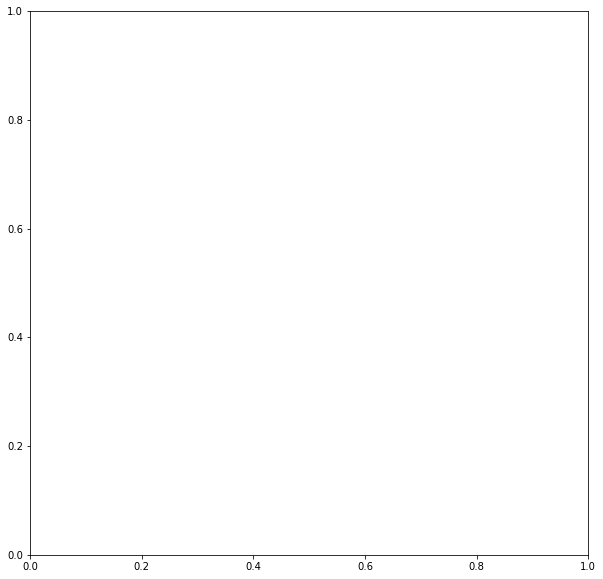

In [192]:
presentation_plot_index = [0,1000,2000,5000,6000] 

fig, ax = plt.subplots(figsize = (10,10));

x1data = []
x2data = []
y1data = []
y2data = []

for datapoint in presentation_plot_index:
    

    mu1 = [dvar_pred.iloc[datapoint]['CMR_fine'], dvar_pred.iloc[datapoint]['CMR_coarse']]
    sigma1 = [dvar_pred.iloc[datapoint]['GSD_fine'], dvar_pred.iloc[datapoint]['GSD_coarse']]
    mu2 = [dvar_test.iloc[datapoint]['CMR_fine'], dvar_test.iloc[datapoint]['CMR_coarse']]
    sigma2 = [dvar_test.iloc[datapoint]['GSD_fine'], dvar_test.iloc[datapoint]['GSD_coarse']]
    Vtot1 = dvar_pred.iloc[datapoint]['V_tot']
    Vtot2 = dvar_test.iloc[datapoint]['V_tot']
    
    
    x1 = np.linspace(0.01, 10, 100000)
    x2 = np.linspace(0.01, 10, 100000)
    
    pdf1 = [(Vtot1 / (np.sqrt(2 * np.pi) * np.log(sigma1[0]))) * np.exp((-np.square((np.log(x) - np.log(mu1[0])))) / (2 * np.square(np.log(sigma1[0])))) +
             (Vtot1 / (np.sqrt(2 * np.pi) * np.log(sigma1[1]))) * np.exp((-np.square((np.log(x) - np.log(mu1[1])))) / (2 * np.square(np.log(sigma1[1])))) for x in x1]
    
            
    pdf2 = [(Vtot2 / (np.sqrt(2 * np.pi) * np.log(sigma2[0]))) * np.exp((-np.square((np.log(x) - np.log(mu2[0])))) / (2 * np.square(np.log(sigma2[0])))) +
             (Vtot2 / (np.sqrt(2 * np.pi) * np.log(sigma2[1]))) * np.exp((-np.square((np.log(x) - np.log(mu2[1])))) / (2 * np.square(np.log(sigma2[1])))) for x in x2]
    

    
    x1data.append(x1)
    x2data.append(x2)
    y1data.append(pdf1)
    y2data.append(pdf2)


0


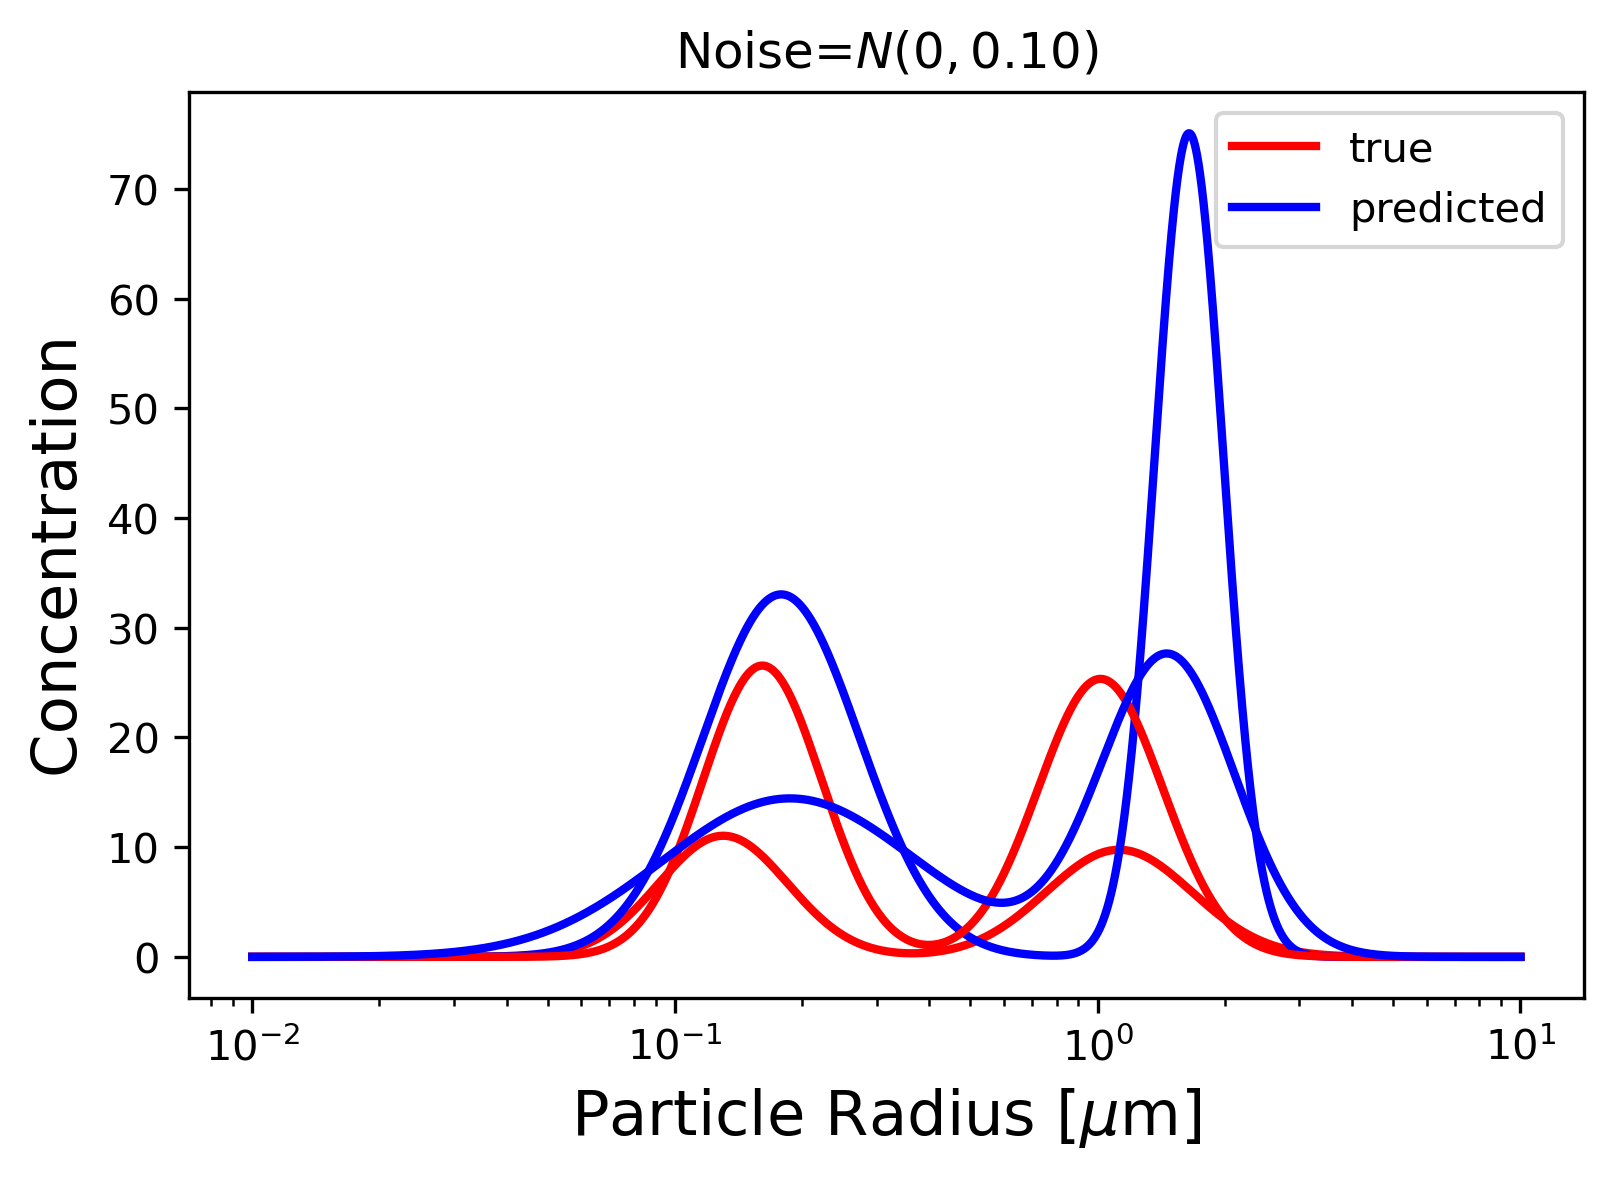

In [193]:
print(presentation_plot_index[0])
plt.figure(dpi=300)
plt.xlabel('Particle Radius [$\mu$m]', fontsize = 15)
plt.ylabel('Concentration ', fontsize=15)  
plt.title('Noise=$N(0,0.10)$')
#plt.title("No Noise")
i=0

plt.plot(x2data[i], y2data[i], '-r', lw=2, label="true")
plt.plot(x1data[i], y1data[i], '-b', lw=2, label="predicted")

plt.plot(x2data[i+1], y2data[i+1], '-r', lw=2)
plt.plot(x1data[i+1], y1data[i+1], '-b', lw=2)

plt.legend()
plt.xscale('log')
plt.savefig(f'{plot_dir}/inv_bimodal_dist_0.00train_0.10test.jpg')

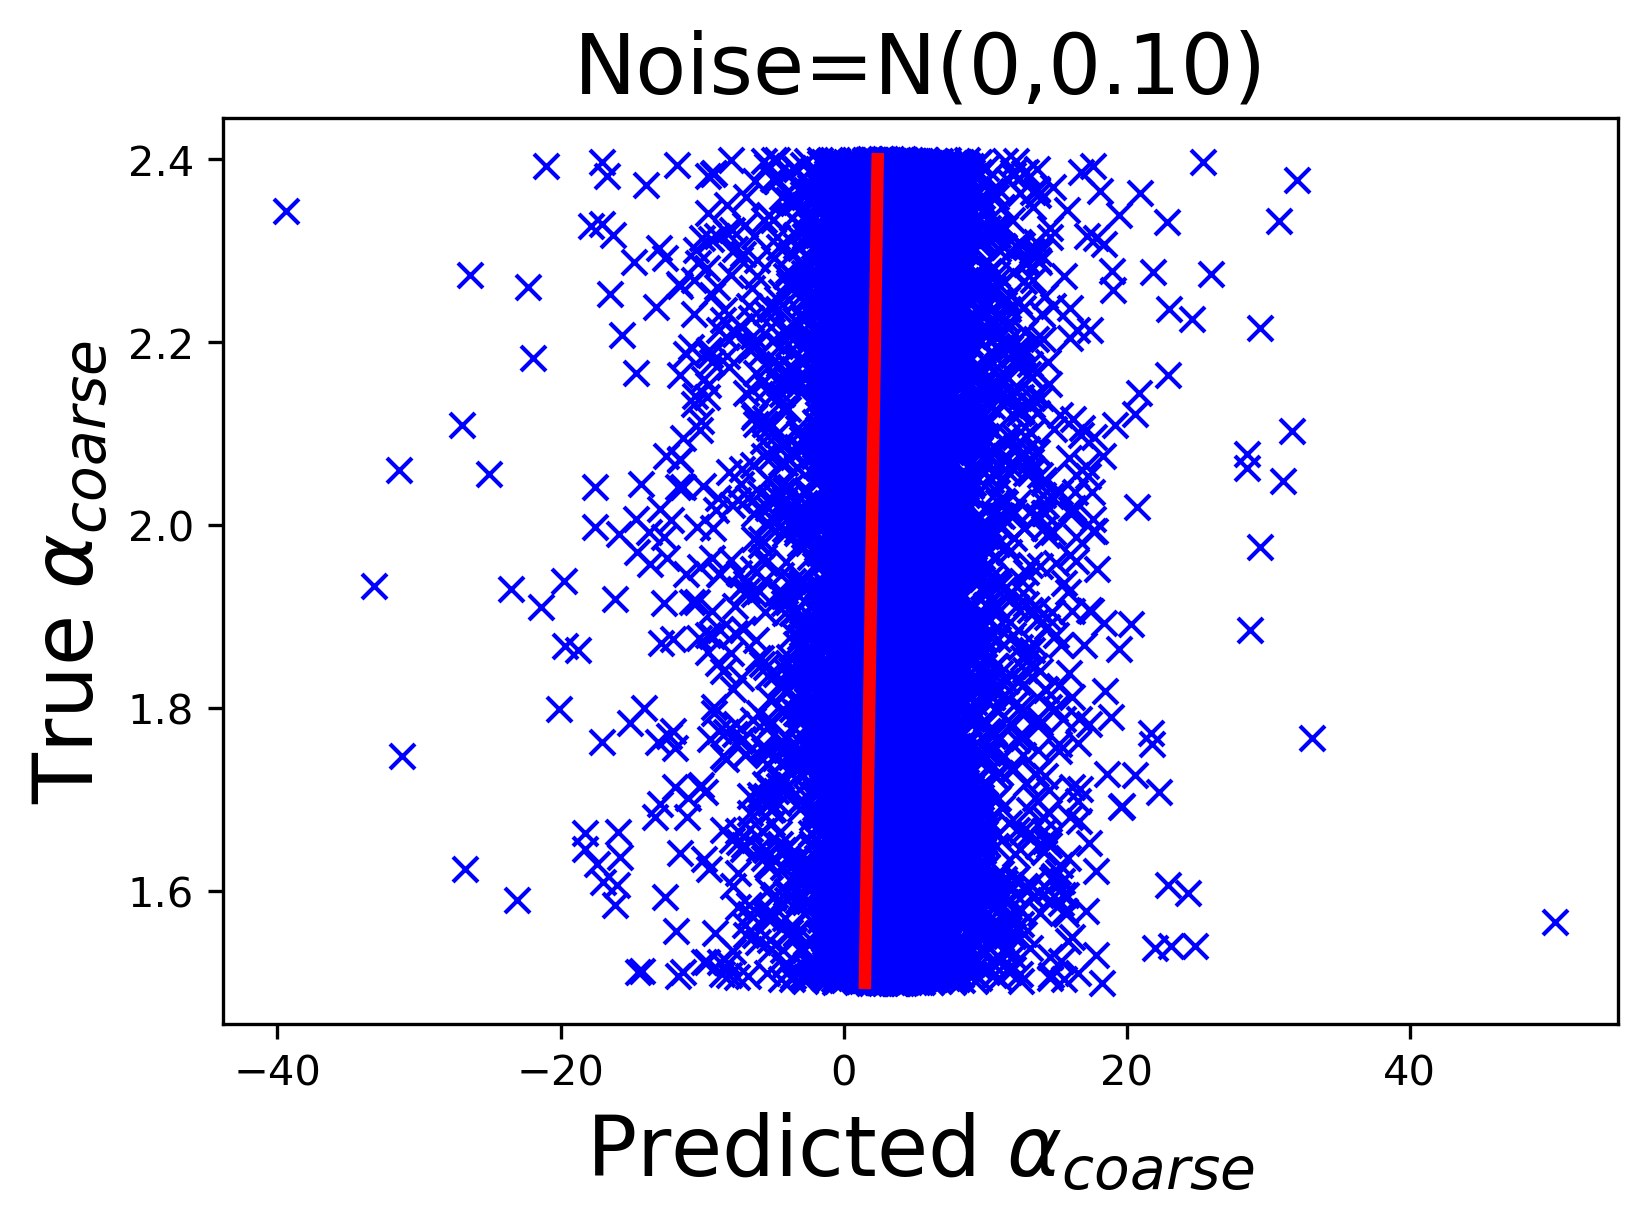

In [194]:
plt.figure(dpi=300)
plt.title("Noise=N(0,0.10)", fontsize=20)
#plt.title("No Noise", fontsize=20)
plt.xlabel(r'Predicted $\alpha_{coarse}$', fontsize=20)
plt.ylabel(r'True $\alpha_{coarse}$', fontsize=20)
x = dvar_pred['AAE_coarse']
y = dvar_test['AAE_coarse']
plt.plot(x,y, 'bx')
plt.plot([1.5,2.4],[1.5,2.4], 'r-', lw=3)

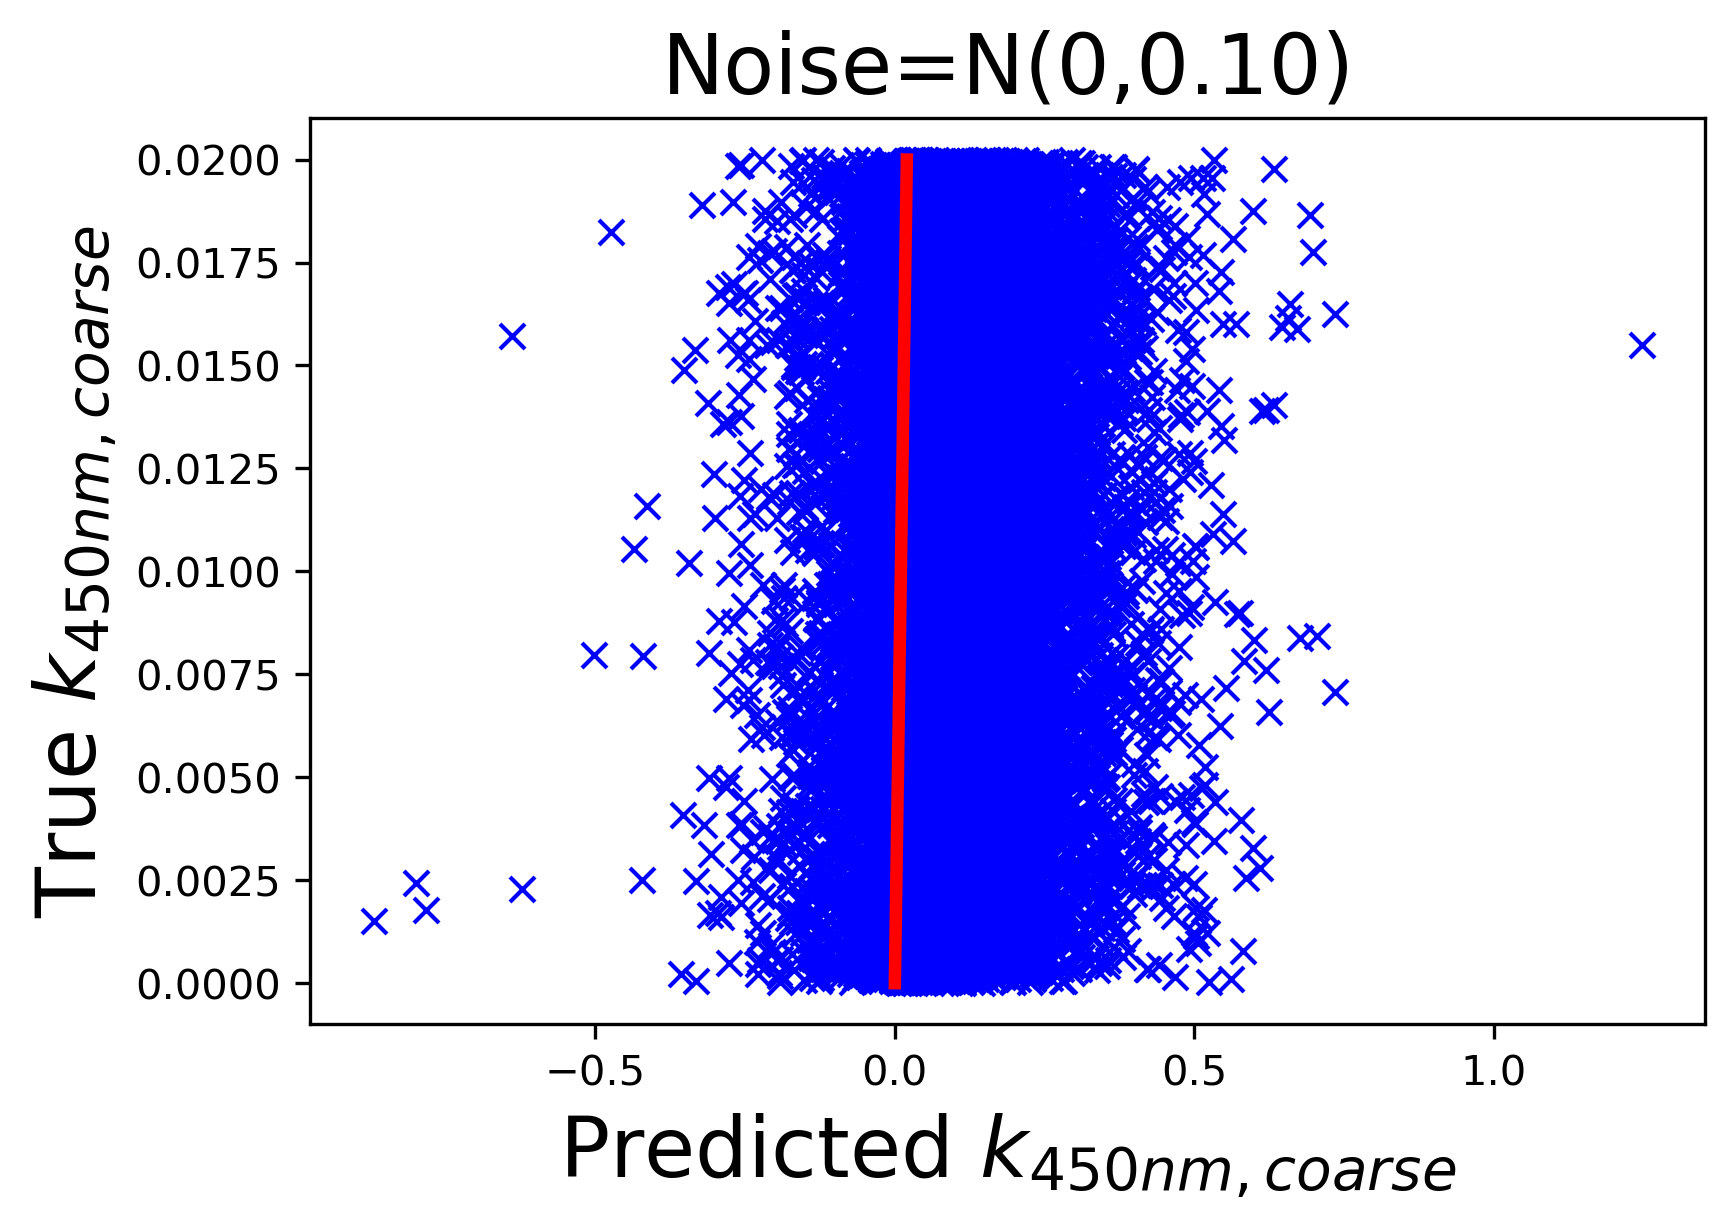

In [195]:
plt.figure(dpi=300)
plt.title("Noise=N(0,0.10)", fontsize=20)
#plt.title("No Noise", fontsize=20)
plt.xlabel(r'Predicted $k_{450nm,coarse}$', fontsize=20)
plt.ylabel(r'True $k_{450nm,coarse}$', fontsize=20)
x = dvar_pred['k_450nm_coarse']
y = dvar_test['k_450nm_coarse']
plt.plot(x,y, 'bx')
plt.plot([0,0.02],[0,0.02], 'r-', lw=3)

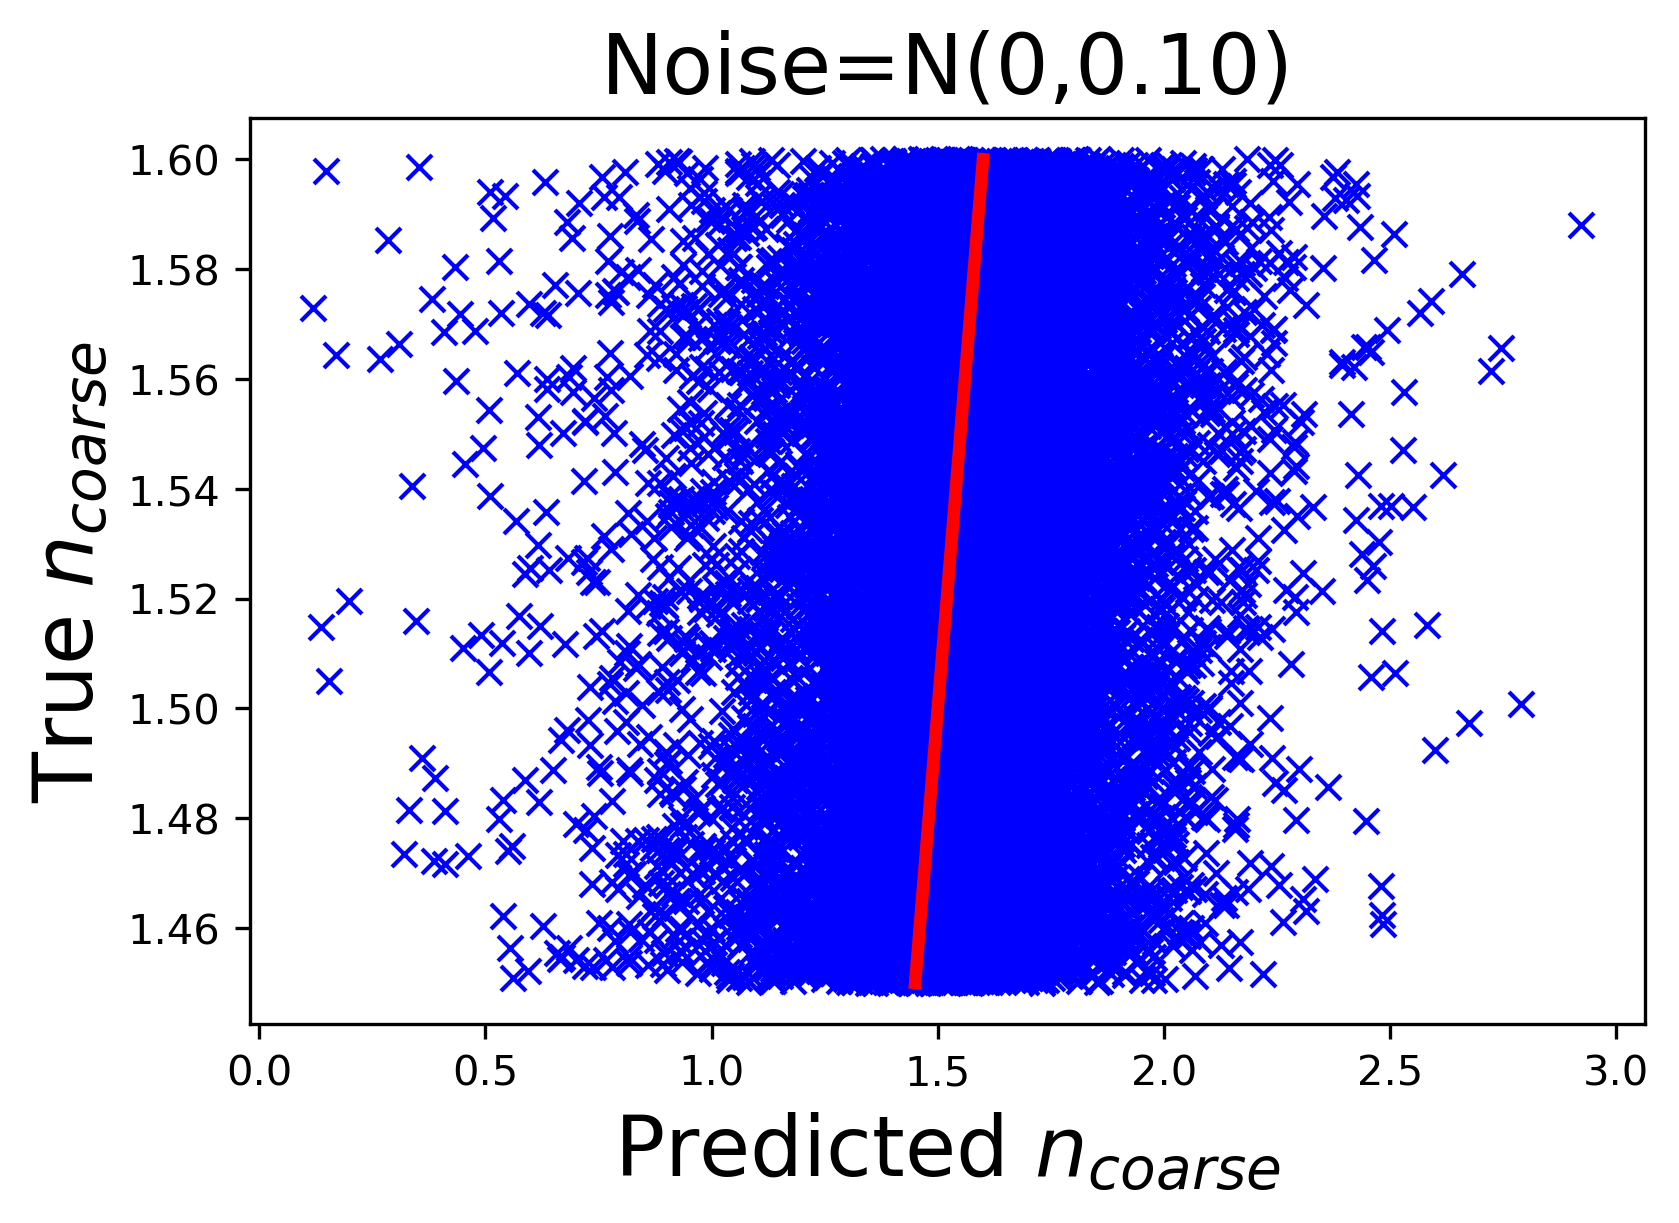

In [196]:
plt.figure(dpi=300)
plt.title("Noise=N(0,0.10)", fontsize=20)
#plt.title("No Noise", fontsize=20)
plt.xlabel(r'Predicted $n_{coarse}$', fontsize=20)
plt.ylabel(r'True $n_{coarse}$', fontsize=20)
x = dvar_pred['n_coarse']
y = dvar_test['n_coarse']
plt.plot(x,y, 'bx')
plt.plot([1.45,1.6],[1.45,1.6], 'r-', lw=3)